### Подключение к базе и основные таблицы

In [1]:
import pandas as pd

### Данные по пользователям

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [2]:
### Посты и топики

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
### Почти 77 миллионов данных, достаточно тяжело
### Попробуем забрать, скажем, 10 миллионов

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 10000000""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-22 22:26:22,163191,4012,view,0
1,2021-11-22 22:27:18,163191,7278,view,0
2,2021-11-22 22:29:04,163191,1562,view,0
3,2021-11-22 22:30:45,163191,1183,view,0
4,2021-11-22 22:31:10,163191,3373,view,0


### Работа с данными и фичи для контентной модели

In [4]:
### Как устроена колонка target?

feed_data[feed_data.action!='view']

,timestamp,user_id,post_id,action,target
10,2021-11-25 06:59:33,163191,2353,like,0
16,2021-11-25 07:03:05,163191,765,like,0
43,2021-11-26 16:58:29,163191,2437,like,0
47,2021-11-26 17:03:37,163191,6100,like,0
51,2021-11-26 17:08:42,163191,1190,like,0
...,...,...,...,...,...
9999963,2021-12-12 22:18:30,130867,1556,like,0
9999965,2021-12-12 22:18:45,130867,1725,like,0
9999982,2021-12-13 22:39:57,130867,894,like,0
9999986,2021-12-13 22:41:38,130867,3681,like,0


In [5]:
### Почистим данные от action != view

feed_data = feed_data[feed_data.action == 'view']

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-22 22:26:22,163191,4012,view,0
1,2021-11-22 22:27:18,163191,7278,view,0
2,2021-11-22 22:29:04,163191,1562,view,0
3,2021-11-22 22:30:45,163191,1183,view,0
4,2021-11-22 22:31:10,163191,3373,view,0


Напомним, как устроен контентный подход! 

Научимся по выбранной дате timestamp 

И для любой пары (user_id, post_id)

Предсказывать, случится лайк или нет

Хорошо бы иметь модель, которая умеет предсказывать вероятности

In [6]:
### Сделаем эмбеддинги постов
from transformers import AutoTokenizer
from transformers import BertModel  
from transformers import RobertaModel  
from transformers import DistilBertModel  


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']

    checkpoint_names = {
        'bert': 'bert-base-cased',  
        'roberta': 'roberta-base',  
        'distilbert': 'distilbert-base-cased'  
    }

    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }

    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [7]:
tokenizer, model = get_model('distilbert')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
### Сделаем датасет для постов

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding


class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])
    
    
dataset = PostDataset(posts_info['text'].values.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loader = DataLoader(dataset, batch_size=32, collate_fn=data_collator, pin_memory=True, shuffle=False)

b = next(iter(loader))

b

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[  101,  1993,  4190,  ...,     0,     0,     0],
        [  101, 15386,  1116,  ...,  1300,  1107,   102],
        [  101,  3141,   186,  ..., 14099,  8478,   102],
        ...,
        [  101, 16972, 20647,  ...,     0,     0,     0],
        [  101,   137,   188,  ...,     0,     0,     0],
        [  101,   144, 22731,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [12]:
import torch
from tqdm import tqdm


@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    
    for batch in tqdm(loader):
        batch = {key: batch[key] for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)

In [13]:
embeddings = get_embeddings_labels(model, loader).numpy()

embeddings

100%|██████████████████████████████████████████████████████████████████████████████| 220/220 [1:05:48<00:00, 17.95s/it]


array([[ 3.63150924e-01,  4.89375107e-02, -2.64081419e-01, ...,
        -1.41593292e-01,  1.59181058e-02,  9.18474980e-05],
       [ 2.36416146e-01, -1.59501195e-01, -3.27798426e-01, ...,
        -2.89936155e-01,  1.19365156e-01, -1.62365846e-03],
       [ 3.75191331e-01, -1.13943920e-01, -2.40547195e-01, ...,
        -3.38919163e-01,  5.86937591e-02, -2.12656315e-02],
       ...,
       [ 3.40382338e-01,  6.64923489e-02, -1.63184568e-01, ...,
        -8.65626335e-02,  2.03403682e-01,  3.20905708e-02],
       [ 4.32092071e-01,  1.10913180e-02, -1.17306173e-01, ...,
         7.54014030e-02,  1.02739736e-01,  1.52741875e-02],
       [ 3.04277599e-01, -7.62156248e-02, -6.77586049e-02, ...,
        -5.43486886e-02,  2.44383708e-01, -1.41484234e-02]], dtype=float32)

In [14]:
### Пытаемся кластеризовать тексты

from sklearn.decomposition import PCA

centered = embeddings - embeddings.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,3.616151,2.781937,2.129449,3.311830,3.344322,3.361424,3.446324,1.538041,1.974776,3.295753,3.235520,2.676168,3.309427,3.259037,3.455668
1,3.323915,2.593108,2.099549,3.203233,2.966148,3.098223,3.215325,1.433588,1.948594,2.770639,3.192605,2.343420,3.119880,3.207541,3.123698
2,3.403460,2.866899,2.201709,3.240261,2.969944,3.288276,3.361239,1.363335,2.837833,2.775573,3.126767,2.711601,3.264036,3.364674,3.119988
3,2.868227,3.099598,2.596359,3.611990,3.661294,3.934768,3.488706,2.125236,3.204794,3.554612,3.383046,3.222034,3.637525,3.573189,3.684079
4,3.077535,2.385759,1.551883,2.615346,2.613929,3.012942,2.878095,1.346815,2.677017,2.413462,2.835116,1.805208,2.538186,2.544257,2.739068


In [15]:
posts_info = pd.concat((posts_info, dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,7,3.616151,2.781937,2.129449,3.311830,3.344322,3.361424,3.446324,1.538041,1.974776,3.295753,3.235520,2.676168,3.309427,3.259037,3.455668
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,7,3.323915,2.593108,2.099549,3.203233,2.966148,3.098223,3.215325,1.433588,1.948594,2.770639,3.192605,2.343420,3.119880,3.207541,3.123698
2,3,Asian quake hits European shares\n\nShares in ...,business,7,3.403460,2.866899,2.201709,3.240261,2.969944,3.288276,3.361239,1.363335,2.837833,2.775573,3.126767,2.711601,3.264036,3.364674,3.119988
3,4,India power shares jump on debut\n\nShares in ...,business,7,2.868227,3.099598,2.596359,3.611990,3.661294,3.934768,3.488706,2.125236,3.204794,3.554612,3.383046,3.222034,3.637525,3.573189,3.684079
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,7,3.077535,2.385759,1.551883,2.615346,2.613929,3.012942,2.878095,1.346815,2.677017,2.413462,2.835116,1.805208,2.538186,2.544257,2.739068


In [16]:
posts_info['topic'] = posts_info['topic'].map(pd.merge(
            feed_data,
            posts_info.drop('text', axis=1),
            on='post_id',
            how='left').groupby('topic')['target'].mean())

In [17]:
posts_info.to_sql(    
   "posts_info_features",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                      
    schema="public",                   
    if_exists='replace'            
   ) 

23

## Фичи юзеров

In [20]:
user_info

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [21]:
user_info['city'] = user_info['city'].map(pd.merge(
            feed_data,
            user_info[['user_id', 'city']],
            on='user_id',
            how='left').groupby('city')['target'].mean())

In [22]:
user_info['exp_group'] = user_info['exp_group'].map(pd.merge(
            feed_data,
            user_info[['user_id', 'exp_group']],
            on='user_id',
            how='left').groupby('exp_group')['target'].mean())

In [23]:
user_info['country'] = user_info['country'].map(pd.merge(
            feed_data,
            user_info[['user_id', 'country']],
            on='user_id',
            how='left').groupby('country')['target'].mean())

In [25]:
user_info = user_info.drop(['os', 'source'], axis=1)
user_info

,user_id,gender,age,country,city,exp_group
0,200,1,34,0.112345,0.157534,0.092783
1,201,0,37,0.112345,0.126107,0.093882
2,202,1,17,0.112345,0.146907,0.112781
3,203,0,18,0.112345,0.156383,0.148389
4,204,0,36,0.112345,0.151846,0.092783
...,...,...,...,...,...,...
163200,168548,0,36,0.112345,0.069979,0.112781
163201,168549,0,18,0.112345,0.084283,0.147886
163202,168550,1,41,0.112345,0.079469,0.112781
163203,168551,0,38,0.112345,0.156383,0.092783


In [28]:
query = pd.read_sql(
    """SELECT AVG(f.target) 
    FROM public.feed_data f
    JOIN public.user_data u on f.user_id = u.user_id
    WHERE NOT f.action = 'like'
    GROUP BY f.user_id;""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

query

,avg
0,0.120112
1,0.084058
2,0.136578
3,0.190031
4,0.166667
...,...
163200,0.055249
163201,0.087302
163202,0.102981
163203,0.100629


In [29]:
user_info['avglike'] = query
user_info

,user_id,gender,age,country,city,exp_group,avglike
0,200,1,34,0.112345,0.157534,0.092783,0.120112
1,201,0,37,0.112345,0.126107,0.093882,0.084058
2,202,1,17,0.112345,0.146907,0.112781,0.136578
3,203,0,18,0.112345,0.156383,0.148389,0.190031
4,204,0,36,0.112345,0.151846,0.092783,0.166667
...,...,...,...,...,...,...,...
163200,168548,0,36,0.112345,0.069979,0.112781,0.055249
163201,168549,0,18,0.112345,0.084283,0.147886,0.087302
163202,168550,1,41,0.112345,0.079469,0.112781,0.102981
163203,168551,0,38,0.112345,0.156383,0.092783,0.100629


In [34]:
user_info.to_sql(    
   "user_info_features",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                      
    schema="public",                   
    if_exists='replace'            
   ) 

205

In [35]:
### Воспроизведем датафрейм со всеми новыми фичами 

df = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-11-22 22:26:22,163191,4012,view,0,"Yes. The flu is still with us, polio (my Mum w...",0.119733,10,2.988754,1.283182,...,3.262780,1.706741,2.619080,3.007993,2.788372,1.195037,2.550451,2.585284,2.413553,1.494508
1,2021-11-22 22:27:18,163191,7278,view,0,"To quote one critics review of the movie, it s...",0.120906,13,1.973807,2.637238,...,3.573424,3.133831,2.971905,3.237572,3.420158,3.131981,2.363275,1.481194,0.834080,2.834556
2,2021-11-22 22:29:04,163191,1562,view,0,Isinbayeva heads for Birmingham\n\nOlympic pol...,0.123278,9,3.189322,2.903023,...,2.993153,3.285961,2.557262,3.162044,1.439305,3.099500,2.446939,2.941247,2.900675,3.120811
3,2021-11-22 22:30:45,163191,1183,view,0,Mandelson warning to BBC\n\nThe BBC should ste...,0.113042,8,3.636349,3.340171,...,2.789116,3.750134,2.697338,0.764434,3.223720,3.796567,2.487073,3.278490,3.400709,3.497838
4,2021-11-22 22:31:10,163191,3373,view,0,Were here for you. \n\nIt may be the wee...,0.119733,14,3.104852,1.146858,...,3.372981,1.358157,2.920588,3.066396,3.180960,2.111998,2.701241,2.782990,2.610968,1.065421


In [36]:
df = pd.merge(df,
              user_info,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,avglike
0,2021-11-22 22:26:22,163191,4012,view,0,"Yes. The flu is still with us, polio (my Mum w...",0.119733,10,2.988754,1.283182,...,2.550451,2.585284,2.413553,1.494508,1,52,0.112345,0.089297,0.147886,0.112523
1,2021-11-22 22:27:18,163191,7278,view,0,"To quote one critics review of the movie, it s...",0.120906,13,1.973807,2.637238,...,2.363275,1.481194,0.834080,2.834556,1,52,0.112345,0.089297,0.147886,0.112523
2,2021-11-22 22:29:04,163191,1562,view,0,Isinbayeva heads for Birmingham\n\nOlympic pol...,0.123278,9,3.189322,2.903023,...,2.446939,2.941247,2.900675,3.120811,1,52,0.112345,0.089297,0.147886,0.112523
3,2021-11-22 22:30:45,163191,1183,view,0,Mandelson warning to BBC\n\nThe BBC should ste...,0.113042,8,3.636349,3.340171,...,2.487073,3.278490,3.400709,3.497838,1,52,0.112345,0.089297,0.147886,0.112523
4,2021-11-22 22:31:10,163191,3373,view,0,Were here for you. \n\nIt may be the wee...,0.119733,14,3.104852,1.146858,...,2.701241,2.782990,2.610968,1.065421,1,52,0.112345,0.089297,0.147886,0.112523


In [37]:
### А еще научимся выделять признаки
### Из timestamp!
### от времени просмотра может зависеть
### Склонность пользователей лайкать или игнорировать посты

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,avglike,hour,month
0,2021-11-22 22:26:22,163191,4012,view,0,"Yes. The flu is still with us, polio (my Mum w...",0.119733,10,2.988754,1.283182,...,2.413553,1.494508,1,52,0.112345,0.089297,0.147886,0.112523,22,11
1,2021-11-22 22:27:18,163191,7278,view,0,"To quote one critics review of the movie, it s...",0.120906,13,1.973807,2.637238,...,0.834080,2.834556,1,52,0.112345,0.089297,0.147886,0.112523,22,11
2,2021-11-22 22:29:04,163191,1562,view,0,Isinbayeva heads for Birmingham\n\nOlympic pol...,0.123278,9,3.189322,2.903023,...,2.900675,3.120811,1,52,0.112345,0.089297,0.147886,0.112523,22,11
3,2021-11-22 22:30:45,163191,1183,view,0,Mandelson warning to BBC\n\nThe BBC should ste...,0.113042,8,3.636349,3.340171,...,3.400709,3.497838,1,52,0.112345,0.089297,0.147886,0.112523,22,11
4,2021-11-22 22:31:10,163191,3373,view,0,Were here for you. \n\nIt may be the wee...,0.119733,14,3.104852,1.146858,...,2.610968,1.065421,1,52,0.112345,0.089297,0.147886,0.112523,22,11


In [38]:
### Уберем все ненужные колонки

df = df.drop([
    'action',
    'text',
],
    axis=1)

df = df.set_index(['user_id', 'post_id'])

df.head(50)

timestamp  target     topic  TextCluster  \
user_id post_id                                                      
163191  4012    2021-11-22 22:26:22       0  0.119733           10   
        7278    2021-11-22 22:27:18       0  0.120906           13   
        1562    2021-11-22 22:29:04       0  0.123278            9   
        1183    2021-11-22 22:30:45       0  0.113042            8   
        3373    2021-11-22 22:31:10       0  0.119733           14   
        5012    2021-11-25 06:51:41       0  0.120906           12   
        5470    2021-11-25 06:54:07       0  0.120906            3   
        2979    2021-11-25 06:54:35       0  0.119733            1   
        766     2021-11-25 06:56:50       0  0.122398           11   
        2353    2021-11-25 06:57:15       1  0.119733           10   
        5092    2021-11-25 06:59:35       0  0.120906           13   
        5463    2021-11-25 07:00:03       0  0.120906           13   
        295     2021-11-25 07:01:15       0  0.118589            7   
        6551    2021-11-25 07:02:38       0  0.120906           13   
        765     2021-11-25 07:02:50       1  0.122398           11   
        4935    2021-11-25 07:03:07       0  0.120906            3   
        1604    2021-11-25 07:05:02       0  0.123278            5   
        1873    2021-11-25 07:06:10       0  0.123278            5   
        51      2021-11-25 07:06:36       0  0.118589            7   
        6406    2021-11-25 07:08:22       0  0.120906           12   
        6539    2021-11-25 07:09:33       0  0.120906           13   
        1761    2021-11-25 07:11:19       0  0.123278            5   
        2432    2021-11-25 07:13:23       0  0.119733           10   
        1169    2021-11-25 07:14:36       0  0.113042            8   
        5231    2021-11-25 07:17:18       0  0.120906            3   
        2809    2021-11-25 07:18:07       0  0.119733            1   
        2150    2021-11-25 07:20:45       0  0.098554            2   
        1074    2021-11-25 07:23:00       0  0.113042            8   
        1124    2021-11-25 07:23:18       0  0.113042            8   
        1189    2021-11-25 07:25:12       0  0.113042            8   
        5692    2021-11-25 07:25:24       0  0.120906            4   
        6819    2021-11-25 07:25:59       0  0.120906            3   
        6803    2021-11-25 07:28:36       0  0.120906            3   
        4326    2021-11-26 16:45:58       0  0.120906           12   
        5815    2021-11-26 16:46:26       0  0.120906           12   
        2909    2021-11-26 16:47:13       0  0.119733           10   
        2345    2021-11-26 16:47:50       0  0.119733            6   
        6009    2021-11-26 16:50:11       0  0.120906            0   
        4310    2021-11-26 16:52:41       0  0.120906            3   
        1275    2021-11-26 16:53:53       0  0.113042            8   
        2437    2021-11-26 16:56:06       1  0.119733           14   
        6863    2021-11-26 16:58:31       0  0.120906            4   
        765     2021-11-26 16:59:49       0  0.122398           11   
        6100    2021-11-26 17:01:27       1  0.120906           12   
        1686    2021-11-26 17:03:39       0  0.123278            9   
        1482    2021-11-26 17:06:07       0  0.123278            9   
        1190    2021-11-26 17:06:32       1  0.113042            8   
        1874    2021-11-26 17:08:44       0  0.123278            5   
        5044    2021-11-26 17:08:57       0  0.120906            3   
        712     2021-11-26 17:11:15       0  0.122398            2   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
163191  4012                 2.988754              1.283182   
        7278                 1.973807              2.637238   
        1562                 3.189322              2.903023   
        1183                 3.636349              3.340171   
       

### Пора обучать модели! 

In [39]:
X = df.drop(['target', 'timestamp'], axis=1)
Y = df['target']

### Обучим логистическую регрессию

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.2)
pipe = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression(penalty='none'))])
pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LR', LogisticRegression(penalty='none'))])

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay
import numpy as np


def metric(X_test, Y_test, pipe):
    print(f'Accuracy равно: {accuracy_score(Y_test, pipe.predict(X_test)):.3f}' )
    print(f'Precision равно: {precision_score(Y_test, pipe.predict(X_test)):.3f}' )
    print(f'Recall равно: {recall_score(Y_test, pipe.predict(X_test)):.3f}' )
    print(f'F-мера равно: {f1_score(Y_test, pipe.predict(X_test)):.3f}' )
    
    
    precision, recall, thresholds = precision_recall_curve(Y_test, pipe.predict_proba(X_test)[:, 1])
    f_scores = 2 * precision * recall / (precision + recall)
    print("Best F-score: ", np.max(f_scores))
    print("Threshold for Best F-score: ", thresholds[np.argmax(f_scores)])
    

    fpr, tpr, thresholds = roc_curve(Y_test, pipe.predict_proba(X_test)[:, 1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    print(auc(fpr, tpr))
    
    
    precision, recall, thresholds = precision_recall_curve(Y_test, pipe.predict_proba(X_test)[:, 1])
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    print(auc(recall, precision))
    CalibrationDisplay.from_estimator(pipe, X_test, Y_test)
    

In [53]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
def calibr(X_test, y_test, search):
    plt.figure(figsize=(8, 5))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    ### Предсказания модели на тесте и соответствующая калибровочная кривая
    prob_pos = search.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")

    ### Пусть наши предсказания - случайные, то есть для каждого объекта
    ### вероятность принадлежности + классу это просто случайное число [0; 1]
    prob_pos = np.random.uniform(size=(X_test.shape[0],))
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")

    plt.ylabel("Fraction of positives")
    plt.xlabel("Mean predicted value")
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="lower right")
    plt.title('Calibration plots  (reliability curve)')
    plt.tight_layout()

Accuracy равно: 0.881
Precision равно: 0.344
Recall равно: 0.000
F-мера равно: 0.001


C:\Users\OMEN\AppData\Local\Temp\ipykernel_8244\1618428397.py:19: RuntimeWarning: invalid value encountered in true_divide
  f_scores = 2 * precision * recall / (precision + recall)


Best F-score:  nan
Threshold for Best F-score:  0.5935431225323767
0.6503859830027826
0.1877388480146724


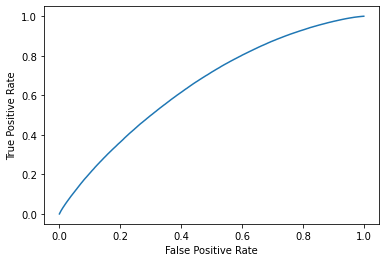

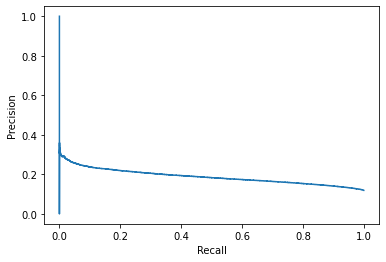

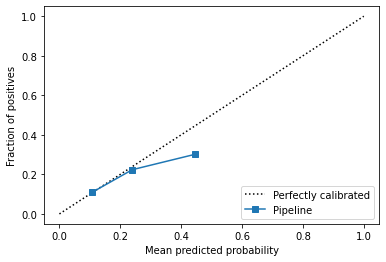

In [45]:
metric(X_test, Y_test, pipe)

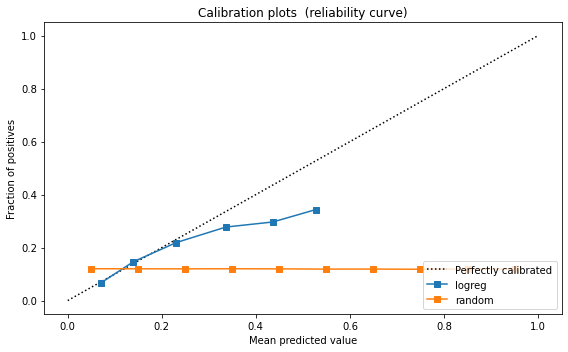

In [54]:
calibr(X_test, Y_test, pipe)

C:\Users\OMEN\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\OMEN\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


Accuracy равно: 0.881
Precision равно: 0.158
Recall равно: 0.000
F-мера равно: 0.001
Best F-score:  0.23944269897513626
Threshold for Best F-score:  0.11616161616161616
0.5936498024120068
0.15465269548748664


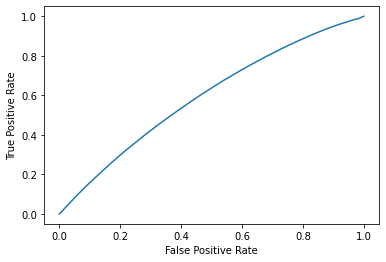

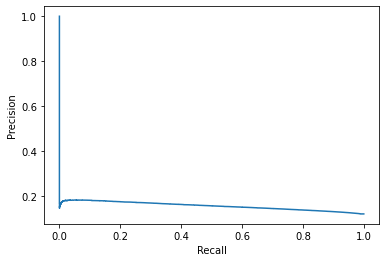

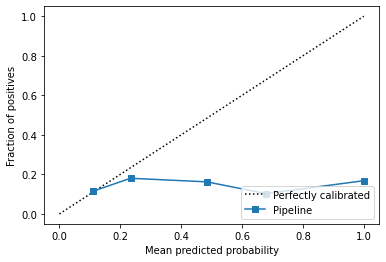

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder


t = [
    ('OneHotEncoder', OneHotEncoder(), ['gender']),
    ('MeanTargetEncoder', TargetEncoder(), ['age', 'hour', 'month', 'TextCluster'])
]
col_transform = ColumnTransformer(transformers=t)
pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeClassifier())])
pipe_dt.fit(X_train, Y_train)
metric(X_test, Y_test, pipe_dt)

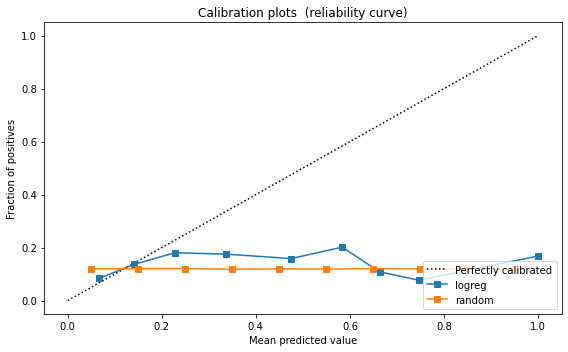

In [55]:
calibr(X_test, Y_test, pipe_dt)

In [56]:
### Обучим катбуст!

from catboost import CatBoostClassifier


catboost = CatBoostClassifier(
    iterations=200,
    learning_rate=1,
    depth=2,
    random_seed=12345
)

object_cols = [
    'TextCluster', 'gender', 'age', 'hour', 'month',
]

catboost.fit(X, Y, object_cols)

0:	learn: 0.3559338	total: 1.73s	remaining: 5m 44s
1:	learn: 0.3536139	total: 3.24s	remaining: 5m 20s
2:	learn: 0.3527422	total: 4.88s	remaining: 5m 20s
3:	learn: 0.3517947	total: 6.11s	remaining: 4m 59s
4:	learn: 0.3514272	total: 7.3s	remaining: 4m 44s
5:	learn: 0.3509974	total: 8.66s	remaining: 4m 39s
6:	learn: 0.3503634	total: 10.3s	remaining: 4m 43s
7:	learn: 0.3501901	total: 11.7s	remaining: 4m 39s
8:	learn: 0.3500628	total: 12.9s	remaining: 4m 33s
9:	learn: 0.3471860	total: 14.5s	remaining: 4m 35s
10:	learn: 0.3468825	total: 15.9s	remaining: 4m 33s
11:	learn: 0.3462745	total: 17.3s	remaining: 4m 30s
12:	learn: 0.3461821	total: 18.9s	remaining: 4m 32s
13:	learn: 0.3461157	total: 20.3s	remaining: 4m 30s
14:	learn: 0.3460088	total: 21.8s	remaining: 4m 29s
15:	learn: 0.3459133	total: 23.3s	remaining: 4m 27s
16:	learn: 0.3457951	total: 24.6s	remaining: 4m 24s
17:	learn: 0.3457387	total: 25.6s	remaining: 4m 19s
18:	learn: 0.3456927	total: 26.9s	remaining: 4m 16s
19:	learn: 0.3456518	to

157:	learn: 0.3432126	total: 3m 13s	remaining: 51.5s
158:	learn: 0.3432071	total: 3m 15s	remaining: 50.3s
159:	learn: 0.3432017	total: 3m 16s	remaining: 49.1s
160:	learn: 0.3431924	total: 3m 17s	remaining: 47.9s
161:	learn: 0.3431879	total: 3m 18s	remaining: 46.7s
162:	learn: 0.3431814	total: 3m 20s	remaining: 45.4s
163:	learn: 0.3431755	total: 3m 21s	remaining: 44.2s
164:	learn: 0.3431696	total: 3m 22s	remaining: 42.9s
165:	learn: 0.3431684	total: 3m 23s	remaining: 41.7s
166:	learn: 0.3431671	total: 3m 24s	remaining: 40.4s
167:	learn: 0.3431639	total: 3m 25s	remaining: 39.2s
168:	learn: 0.3431601	total: 3m 27s	remaining: 38s
169:	learn: 0.3431548	total: 3m 28s	remaining: 36.8s
170:	learn: 0.3431503	total: 3m 29s	remaining: 35.6s
171:	learn: 0.3431467	total: 3m 30s	remaining: 34.3s
172:	learn: 0.3431410	total: 3m 31s	remaining: 33.1s
173:	learn: 0.3431372	total: 3m 33s	remaining: 31.8s
174:	learn: 0.3431323	total: 3m 34s	remaining: 30.6s
175:	learn: 0.3431274	total: 3m 35s	remaining: 2

Accuracy равно: 0.881
Precision равно: 0.346
Recall равно: 0.000
F-мера равно: 0.000
Best F-score:  0.29044773757232667
Threshold for Best F-score:  0.13543593133513732
0.6831317071615597
0.2065321394027293


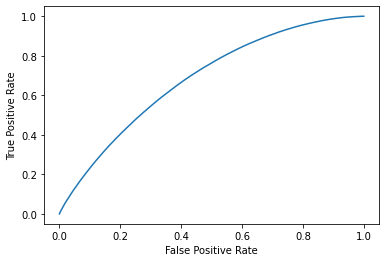

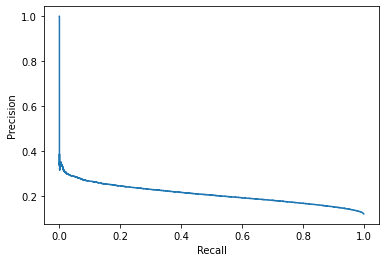

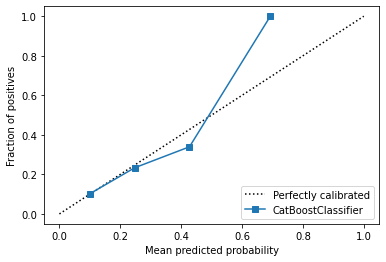

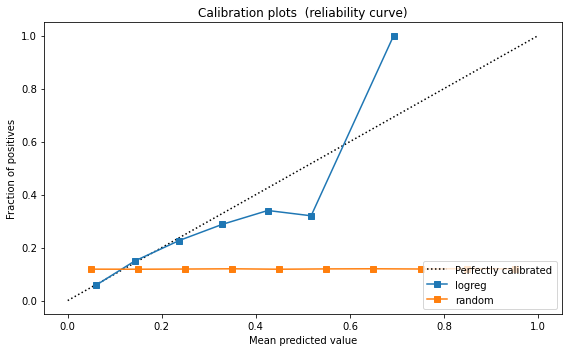

In [57]:
metric(X_test, Y_test, catboost)
calibr(X_test, Y_test, catboost)

In [58]:
### Сохраним модель

catboost.save_model(
    'catboost_model',
    format="cbm"                  
)